In [1]:
import pandas as pd
import networkx as nx
from networkx.algorithms.bipartite.basic import density
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import random
import numpy as np

In [2]:
listenings = pd.read_csv('preprocessed_data/listenings_with_years_and_users.csv',parse_dates=['timestamp','album_date'])
# we only take a look at songs released in the year 2005 and later (when the dataset begins)
listenings = listenings[listenings['album_date'].apply(lambda x: x.year)>=2005]
# we create a unique identifier from artist and track name
listenings['art_tra_name'] = listenings['artname'] + '@' + listenings['traname']
# sort the listenings by time
listenings.sort_values(by='timestamp',inplace=True)
listenings.head()

,userid,timestamp,artname,traname,album_id,album_date,gender,country,art_tra_name
6309509,user_000745,2005-02-14 11:33:33+00:00,Dark Tranquillity,Am I 1?,6e4c7e0b-bb52-4376-a6a1-a7d55a836f38,2005-01-19,m,NaN,Dark Tranquillity@Am I 1?
6309520,user_000745,2005-02-14 11:37:23+00:00,Dark Tranquillity,Dry Run,6e4c7e0b-bb52-4376-a6a1-a7d55a836f38,2005-01-19,m,NaN,Dark Tranquillity@Dry Run
6309500,user_000745,2005-02-14 11:41:33+00:00,Dark Tranquillity,Lost To Apathy,6e4c7e0b-bb52-4376-a6a1-a7d55a836f38,2005-01-19,m,NaN,Dark Tranquillity@Lost To Apathy
6309491,user_000745,2005-02-14 11:45:43+00:00,Dark Tranquillity,Mind Matters,6e4c7e0b-bb52-4376-a6a1-a7d55a836f38,2005-01-19,m,NaN,Dark Tranquillity@Mind Matters
6309513,user_000745,2005-02-14 11:50:43+00:00,Dark Tranquillity,My Negation,6e4c7e0b-bb52-4376-a6a1-a7d55a836f38,2005-01-19,m,NaN,Dark Tranquillity@My Negation


When we look at the degree distribution we can clearly see the typical preferential attachment pattern.

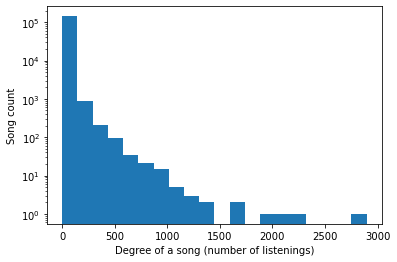

In [3]:
# log scaled degree distribution for songs 

G = nx.MultiGraph()
G.add_nodes_from(listenings['userid'], isSong=False)
G.add_nodes_from(listenings['art_tra_name'], isSong=True)
G.add_edges_from(list(zip(listenings['userid'],listenings['art_tra_name'])),time = listenings['timestamp'])
songDegrees = [G.degree(n) for n,data in G.nodes(data=True) if data['isSong']==True]
plt.hist(songDegrees, bins=20)
plt.xlabel('Degree of a song (number of listenings)')
plt.ylabel('Song count')
plt.yscale('log', nonpositive='clip')
plt.show()

In [4]:
songRanks = listenings.groupby('art_tra_name',as_index=False).count()[['art_tra_name','timestamp']].rename({'timestamp':'nr_of_listens'},axis=1)\
                        .sort_values('nr_of_listens', ascending=False).reset_index(drop=True).reset_index().rename({'index':'rank'},axis=1)
songRanks['rank'] +=1
songRanks

,rank,art_tra_name,nr_of_listens
0,1,Bloc Party@Banquet,2895
1,2,Bloc Party@Blue Light,2212
2,3,The Fray@How To Save A Life,2059
3,4,Bloc Party@This Modern Love,1972
4,5,Bloc Party@Helicopter,1721
...,...,...,...
144536,144537,Isolation Years@That'S All There Is,1
144537,144538,"Isolation Years@Sign, Sign",1
144538,144539,Isolation Years@Say Nothing Day,1
144539,144540,Isolation Years@Mostroems Instrumental,1


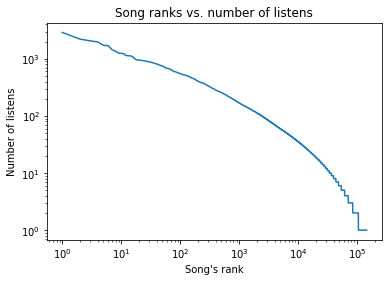

In [6]:
songRanks.plot(x='rank',y='nr_of_listens',title='Song ranks vs. number of listens',legend=None)
plt.xlabel('Song\'s rank')
plt.ylabel('Number of listens')
plt.xscale('log', nonpositive='clip')
plt.yscale('log', nonpositive='clip')

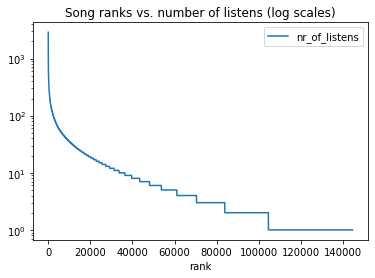

In [6]:
songRanks.plot(x='rank',y='nr_of_listens',title='Song ranks vs. number of listens (log scales)')
#plt.xscale('log', nonpositive='clip')
plt.yscale('log', nonpositive='clip')

We have created a custom metric to express the intensity of preferential attachment phenomena in the data. We loop over the listenings data ordered by the timestamp. At each step we calculate the random probability (1 divided by total number of songs that appeared so far) and popularity weighted probability (number of songs listenings so far divided by total nunmber of listenings of all songs so far). At the end we compara the sums of these probabilities. If the weighted probability was higher it means the preferential attachment has an influence, if the values are the same songs popularity has no effect, if the weighted is lower then users tend to favour unpopular songs. This method makes use of the precise timestamp information since the song popularities are different at each point in time. Another advantage is it naturally deals with the fact that the number of distinct users in the dataset is rising over time.

In [7]:
def pref_attach_intensity(listenings,attrName='art_tra_name',attrFilter=None):
    listenCntsDict = {} #  song_name -> song_listen_count
    listenCntSum = 0 
    randomProbList = []
    popularityWeightedProbList = []
    #maxWeighedProbs = []

    for name,attr in tqdm(zip(listenings['art_tra_name'],listenings[attrName]),total=len(listenings),
                                                     position=0, leave=True):
        # if the song was already listened to at least once
        if (name in listenCntsDict):
            # optional filter using datasets user attributes
            if(attrName=='art_tra_name' or attr==attrFilter):
                # completely random probability
                randomProb = 1/len(listenCntsDict)
                # probability proportional to the number of listenings of the song
                popularityWeightedProb = listenCntsDict[name] / listenCntSum
                #maxWeighedProbs.append(max(listenCntsDict.values())/ listenCntSum)

                randomProbList.append(randomProb)
                popularityWeightedProbList.append(popularityWeightedProb)
            
            listenCntsDict[name] += 1
        # if this is the first time the song is being listened to
        else:
            listenCntsDict[name] = 1

        listenCntSum += 1
    
    return sum(popularityWeightedProbList)/sum(randomProbList)#,sum(maxWeighedProbs)

We test the method on artificial dummy data. We generate 1 million of random song listenings of 1000 distinct songs. As mentioned before, if the preferential attachment is not present in the data the value should be close to 1 which is the case here.

In [8]:
random.seed(0)
N_DISTINCT_SONGS = 1000
N_LISTENINGS = 1000000

artTraNameTest = [random.randint(1,N_DISTINCT_SONGS) for x in range(N_LISTENINGS)]
testDf = pd.DataFrame()
testDf['art_tra_name'] = artTraNameTest
testDf.head()

,art_tra_name
0,865
1,395
2,777
3,912
4,431


In [9]:
pref_attach_intensity(testDf)

100%|██████████| 1000000/1000000 [00:01<00:00, 862013.27it/s]


0.9999717900756318

In [ ]:
random.seed(0)
N_DISTINCT_SONGS = 1000
N_LISTENINGS = 1000000


artTraNameTest = [random.randint(1,N_DISTINCT_SONGS) for x in range(N_LISTENINGS)]
testDf = pd.DataFrame()
testDf['art_tra_name'] = artTraNameTest
testDf.head()

We create another random dataset, but this time the probabilities of song listening are proportional its number of listenings. We get a value of 2 indicating the preferential attachment.

In [63]:
listenCnts = [1.0]*N_DISTINCT_SONGS
probs = [float(i)/sum(listenCnts) for i in listenCnts]
songIds = list(range(N_DISTINCT_SONGS))
artTraNameTest = []
for i in tqdm(range(N_LISTENINGS)):
    song = np.random.choice(songIds, 1, p=probs)[0]
    
    # increase song count for the song - one listening counts as 2
    listenCnts[song] += 1.0
    listenCntSum = (1+i)*1 + 1000
    # normalize the song selection probabilities to sum to 1
    probs = [x/listenCntSum for x in listenCnts]

    artTraNameTest.append(song)
testDf2 = pd.DataFrame()
testDf2['art_tra_name'] = artTraNameTest
testDf2.head()

100%|██████████| 1000000/1000000 [03:43<00:00, 4482.57it/s]


,art_tra_name
0,715
1,995
2,7
3,800
4,977


In [64]:
pref_attach_intensity(testDf2)

100%|██████████| 1000000/1000000 [00:01<00:00, 831120.24it/s]


1.967194602656769

We generate another dataset - this time we double the preferential attachment by counting each song listening as 2. We get a value of 3 which confirms the custom function results increase linearly.

In [60]:
listenCnts = [1.0]*N_DISTINCT_SONGS
probs = [float(i)/sum(listenCnts) for i in listenCnts]
songIds = list(range(N_DISTINCT_SONGS))
artTraNameTest = []
for i in tqdm(range(N_LISTENINGS)):
    song = np.random.choice(songIds, 1, p=probs)[0]
    
    # increase song count for the song - one listening counts as 2
    listenCnts[song] += 2.0
    listenCntSum = (1+i)*2 + 1000
    # normalize the song selection probabilities to sum to 1
    probs = [x/listenCntSum for x in listenCnts]

    artTraNameTest.append(song)
testDf3 = pd.DataFrame()
testDf3['art_tra_name'] = artTraNameTest
testDf3.head()

100%|██████████| 1000000/1000000 [03:43<00:00, 4470.70it/s]


,art_tra_name
0,51
1,420
2,979
3,34
4,998


In [61]:
pref_attach_intensity(testDf3)

100%|██████████| 1000000/1000000 [00:01<00:00, 834565.79it/s]


3.0143353687063845

We calculate the value for the real data, we can see the preferential attachment is a strong phenomenon in this dataset.

In [15]:
pref_attach_intensity(listenings)

100%|██████████| 1726049/1726049 [00:02<00:00, 721665.63it/s]


4.787232306971177

# Comparing preferential attachment for subsets of the dataset based on the attributes

## User's gender

When we calculate the values for different genders in the data we can see we get a slightly bigger results for females.

In [16]:
pref_attach_intensity(listenings,'gender','m')

100%|██████████| 1726049/1726049 [00:02<00:00, 775712.91it/s]


4.188388858152285

In [17]:
pref_attach_intensity(listenings,'gender','f')

100%|██████████| 1726049/1726049 [00:02<00:00, 858226.03it/s]


6.517967836182568

## User's geographical area

In [18]:
europeList = ['United Kingdom', 'Finland', 'Germany', 'Sweden', 'Canada', 'Switzerland',
    'Norway', 'Poland', 'Netherlands', 'Belgium', 'Italy', 'Romania',
       'Russian Federation', 'Spain',
       'Ireland','Czech Republic','France', 'China',
       'Austria', 'Slovakia', 'Malta',
       'Latvia', 'Estonia', 'Lithuania',
      'Iceland', 'Bulgaria',
      'Portugal', 'Croatia',  'Serbia', 'Greece', 'Hungary',
       'Bosnia and Herzegovina', 'Slovenia',
       'Belarus',  'Macedonia']

In [19]:
# we rename the European countries so that we have a bigger geographical group which we can compare to the United States
listenings['country'] = listenings['country'].apply(lambda x: 'Europe' if x in europeList else x)

There is almost no difference between the values for users from these two different geographical areas.

In [20]:
pref_attach_intensity(listenings,'country','United States')

100%|██████████| 1726049/1726049 [00:01<00:00, 910247.95it/s]


5.135018026838303

In [21]:
pref_attach_intensity(listenings,'country','Europe')

100%|██████████| 1726049/1726049 [00:02<00:00, 799264.00it/s]


4.567035054996103

## Song genres

In [22]:
listeningsWithTags = pd.read_csv('preprocessed_data/listenings_with_years_and_tags.csv')
listenings = listenings[listenings['album_date'].apply(lambda x: x.year)>=2005]
listeningsWithTags['art_tra_name'] = listeningsWithTags['artname'] + '@' + listeningsWithTags['traname']
listeningsWithTags.sort_values(by='timestamp',inplace=True)
listeningsWithTags.head()

,userid,timestamp,artname,traname,album_id,album_date,tid,tag,art_tra_name
98181,user_000525,2005-02-14 00:07:16+00:00,Muse,The Small Print,1dad9b13-1f02-33f6-815e-7fb2e6af17ea,2003-09-28,TRAZCOX128F42B6555,rock,Muse@The Small Print
99070,user_000525,2005-02-14 00:07:16+00:00,Muse,The Small Print,1dad9b13-1f02-33f6-815e-7fb2e6af17ea,2003-09-28,TROOXQV128F932B6EF,rock,Muse@The Small Print
97256,user_000525,2005-02-14 00:10:52+00:00,Muse,Endlessly,1dad9b13-1f02-33f6-815e-7fb2e6af17ea,2003-09-28,TRSFZGX128F932B6F0,rock,Muse@Endlessly
110586,user_000525,2005-02-14 00:18:16+00:00,Muse,Ruled By Secrecy,1dad9b13-1f02-33f6-815e-7fb2e6af17ea,2003-09-28,TRSXXLJ128F932B6F2,rock,Muse@Ruled By Secrecy
111358,user_000525,2005-02-14 00:18:16+00:00,Muse,Ruled By Secrecy,1dad9b13-1f02-33f6-815e-7fb2e6af17ea,2003-09-28,TRYYOWT128F42B6558,rock,Muse@Ruled By Secrecy


In [23]:
listeningsWithTags['tag'].unique()

array(['rock', 'indie', 'pop', 'alternative', 'electronic'], dtype=object)

In [24]:
intensities = []
for tag in listeningsWithTags['tag'].unique():
    intensities.append(pref_attach_intensity(listeningsWithTags[listeningsWithTags['tag']==tag]))

100%|██████████| 417426/417426 [00:00<00:00, 746102.16it/s]


Looking at the results differentiated by songs genre we can clearly see indie genre stands out from the others. It is a bit surprising it is not the pop genre where one would expect the users to be attracted to "popular" music the most.

Text(0, 0.5, 'Preferential attachment intensity')

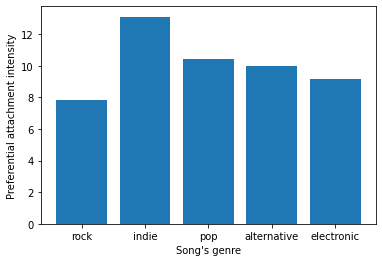

In [25]:
plt.bar(x=listeningsWithTags['tag'].unique(), height=intensities)
plt.xlabel('Song\'s genre')
plt.ylabel('Preferential attachment intensity')